# MICOM analysis

In [1]:
# Add higher directory to python modules path

import sys

sys.path.append("..")

In [2]:
import os
import yaml

import pandas as pd

import micom
from micom import Community, load_pickle

from biofoundry.data.amils2023 import Amils2023DataLoader
from biofoundry.micom import (
    MICOMPreloader,
    MICOMMediumManager,
    plot_abundances_depth,
    plot_minimal_medium
)
from biofoundry.utils import save_fig

In [3]:
def save_sol(
    sol: micom.solution.CommunitySolution,
    path: str
) -> None:
    sol_df = sol.members.copy()
    sol_df["community_growth_rate"] = sol.growth_rate
    sol_df["status"] = sol.status

    sol_df.to_csv(path)

In [4]:
# Load config

with open("../biofoundry/config.yml") as config_file:
    config = yaml.safe_load(config_file)

In [5]:
output_dir = os.path.join(
    config["paths"]["micom"],
    "amils2023"
)

data_loader = Amils2023DataLoader()
preloader = MICOMPreloader(config)

In [6]:
abundances_df = data_loader.get_abundances()
abundances_df

,genus,sample_id,abundance
0,Acidiphilium,BH10-103-Illumina,0.0
1,Aciditerrimonas,BH10-103-Illumina,0.0
2,Acidovorax,BH10-103-Illumina,0.0
3,Acinetobacter,BH10-103-Illumina,0.0
4,Actinobacillus,BH10-103-Illumina,0.0
...,...,...,...
1031,Spirosoma,BH10-496-Roche,0.0
1032,Truepera,BH10-496-Roche,0.0
1033,WPS-1_genera_incertae_sedis,BH10-496-Roche,0.0
1034,Xylanimicrobium,BH10-496-Roche,0.0


In [7]:
metadata_df = pd.read_csv(
    os.path.join(
        config["paths"]["genomes"],
        "genomes-metadata.csv"
    )
)

taxonomy_df = preloader.get_taxonomy(metadata_df)
taxonomy_df

,id,genus,species,reactions,metabolites,file
0,aci,Acidovorax,Acidovorax BoFeN1,1246,1199,../data/gem/aci_formatted.json
1,bme,Brevundimonas,Brevundimonas sp. T2.26MG-97,431,460,../data/gem/bme_formatted.json
2,dmi,Desulfosporosinus,Desulfosporosinus meridiei DEEP,1157,1104,../data/gem/dmi_formatted.json
3,pse,Pseudomonas,Pseudomonas sp. T2.31D-1,1461,1295,../data/gem/pse_formatted.json
4,rhi1,Rhizobium,Rhizobium sp. T2.30D-1.1,712,797,../data/gem/rhi1_formatted.json
5,rhi2,Rhizobium,Rhizobium sp. T2.26MG-112.2,683,773,../data/gem/rhi2_formatted.json
6,rho,Rhodoplanes,Rhodoplanes sp. T2.26MG-98,442,490,../data/gem/rho_formatted.json
7,shw,Shewanella,Shewanella sp. T2.3D-1.1,1324,1193,../data/gem/shw_formatted.json
8,tel,Tessaracoccus,Tessaracoccus lapidicaptus IPBSL-7,1199,1111,../data/gem/tel_formatted.json
9,tez,Tessaracoccus,Tessaracoccus sp. T2.5-30,1197,1114,../data/gem/tez_formatted.json


### Combining taxonomy and abundances

In [8]:
taxonomy_abundances = pd.merge(
    left=taxonomy_df,
    right=abundances_df,
    on="genus",
    how="left"
)

# Combine ID column with sample ID to avoid errors in MICOM due to ID duplicates
taxonomy_abundances["id"] = \
    taxonomy_abundances["id"] + "_" + taxonomy_abundances["sample_id"]

# Replace characters not allowed in MICOM
taxonomy_abundances["id"] = taxonomy_abundances["id"].str.replace("-", "_")

print(
    "[WARNING] Species for which there are no abundance data:\n",
    taxonomy_abundances[taxonomy_abundances["id"].isnull()]["species"].values
)

# Save to file
taxonomy_abundances.to_csv(
    os.path.join(
        output_dir,
        "taxonomy.csv"
    ),
    header=True,
    index=False,
    sep=","
)

[WARNING] Species for which there are no abundance data:
 ['Brevundimonas sp. T2.26MG-97' 'Desulfosporosinus meridiei DEEP'
 'Rhodoplanes sp. T2.26MG-98' 'Shewanella sp. T2.3D-1.1']


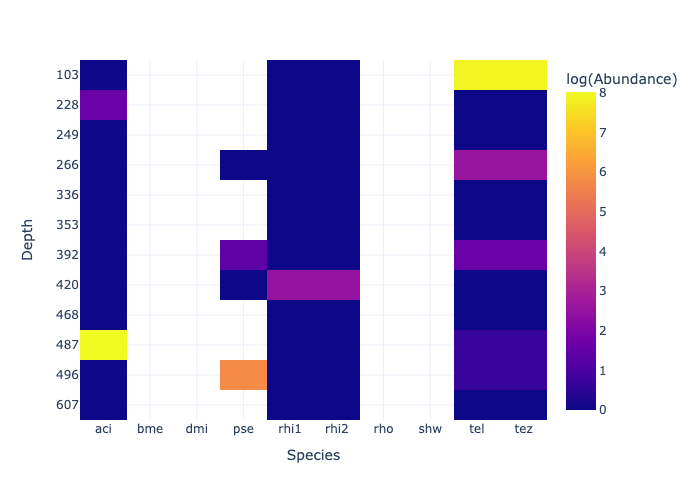

In [9]:
fig = plot_abundances_depth(
    taxonomy_df=taxonomy_abundances,
    config=config
)
fig.show("png")

save_fig(
    fig=fig,
    filename="amils2023-abundances-depth.jpg",
    config=config
)

In [10]:
# WARNING: only Pseudomonas is found in Roche samples
taxonomy_abundances[
    taxonomy_abundances["sample_id"].str.contains("Roche", na=False)
]

,id,genus,species,reactions,metabolites,file,sample_id,abundance,Code,Depth,log_abundance
14,pse_BH10_266_Roche,Pseudomonas,Pseudomonas sp. T2.31D-1,1461,1295,../data/gem/pse_formatted.json,BH10-266-Roche,0.0,pse,266,0.000000
15,pse_BH10_392_Roche,Pseudomonas,Pseudomonas sp. T2.31D-1,1461,1295,../data/gem/pse_formatted.json,BH10-392-Roche,3.0,pse,392,1.386294
16,pse_BH10_420_Roche,Pseudomonas,Pseudomonas sp. T2.31D-1,1461,1295,../data/gem/pse_formatted.json,BH10-420-Roche,0.0,pse,420,0.000000
17,pse_BH10_496_Roche,Pseudomonas,Pseudomonas sp. T2.31D-1,1461,1295,../data/gem/pse_formatted.json,BH10-496-Roche,320.0,pse,496,5.771441


In [11]:
%%script false --no-raise-error

# Build community
com = Community(taxonomy_abundances)

# Save community
com.to_pickle(
    os.path.join(
        output_dir,
        "paper_abundances",
        "community.pickle"
    )
)

In [12]:
%%script false --no-raise-error

# Get tradeoffs
sol = com.cooperative_tradeoff()

# Experiments

### 1. Same abundance among species

1.0. Minimal medium

1.1. Objective: community growth

1.2. Objective: production of metabolite of interest

1.3. Objective: community growth + production of metabolite of interest

1.4. Objective: community growth + production of metabolite of interest + anaerobic conditions

In [13]:
# Create new dataframe with just one sample and equal abundances
taxonomy_abundances_equal = taxonomy_abundances.copy()

# Format for dropping duplicates
taxonomy_abundances_equal["id"] = taxonomy_abundances_equal["Code"].copy()
taxonomy_abundances_equal["sample_id"] = "sample_id"
taxonomy_abundances_equal["abundance"] = 1.0
taxonomy_abundances_equal = taxonomy_abundances_equal\
    .drop(["Code", "Depth", "log_abundance"], axis=1)

# Finally, drop duplicates
taxonomy_abundances_equal = taxonomy_abundances_equal\
    .drop_duplicates()\
    .reset_index(drop=True)

taxonomy_abundances_equal

,id,genus,species,reactions,metabolites,file,sample_id,abundance
0,aci,Acidovorax,Acidovorax BoFeN1,1246,1199,../data/gem/aci_formatted.json,sample_id,1.0
1,bme,Brevundimonas,Brevundimonas sp. T2.26MG-97,431,460,../data/gem/bme_formatted.json,sample_id,1.0
2,dmi,Desulfosporosinus,Desulfosporosinus meridiei DEEP,1157,1104,../data/gem/dmi_formatted.json,sample_id,1.0
3,pse,Pseudomonas,Pseudomonas sp. T2.31D-1,1461,1295,../data/gem/pse_formatted.json,sample_id,1.0
4,rhi1,Rhizobium,Rhizobium sp. T2.30D-1.1,712,797,../data/gem/rhi1_formatted.json,sample_id,1.0
5,rhi2,Rhizobium,Rhizobium sp. T2.26MG-112.2,683,773,../data/gem/rhi2_formatted.json,sample_id,1.0
6,rho,Rhodoplanes,Rhodoplanes sp. T2.26MG-98,442,490,../data/gem/rho_formatted.json,sample_id,1.0
7,shw,Shewanella,Shewanella sp. T2.3D-1.1,1324,1193,../data/gem/shw_formatted.json,sample_id,1.0
8,tel,Tessaracoccus,Tessaracoccus lapidicaptus IPBSL-7,1199,1111,../data/gem/tel_formatted.json,sample_id,1.0
9,tez,Tessaracoccus,Tessaracoccus sp. T2.5-30,1197,1114,../data/gem/tez_formatted.json,sample_id,1.0


In [14]:
# Build community
com = Community(taxonomy_abundances_equal)

# Save community
equal_abundances_path = os.path.join(
    output_dir,
    "equal_abundances/"
    "community.pickle"
)
com.to_pickle(equal_abundances_path)

Output()

### 1.0. Minimal Medium

[11:46:34] WARNING  the MIP version of minimal media is extremely slow for models that large :(         ]8;id=951481;file:///Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/micom/media.py\media.py]8;;\:]8;id=223528;file:///Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/micom/media.py#72\72]8;;\

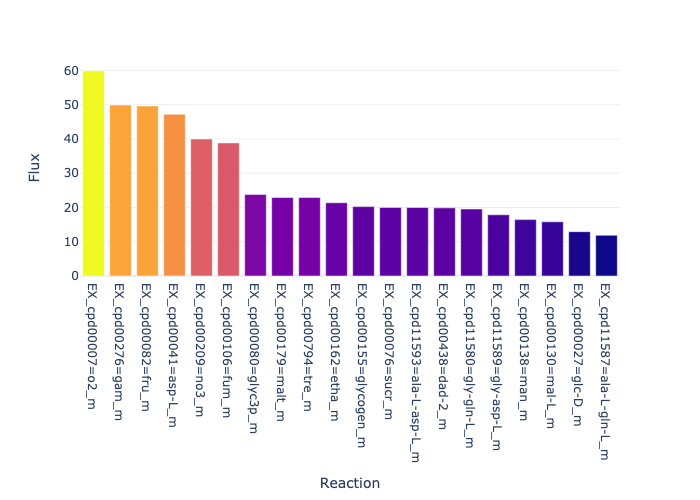

In [15]:
growth_tolerance = 0.85

medium_manager = MICOMMediumManager(config)

min_medium = medium_manager.get_min_medium(
    com=com,
    growth_tolerance=growth_tolerance
)

fig = plot_minimal_medium(
    min_medium=min_medium,
    top_n=20,
    config=config
)
fig.show("png")

save_fig(
    fig=fig,
    filename="micom-limiting-metabolites.jpg",
    config=config
)

In [16]:
medium_df = data_loader.get_data()

# Get maximum concentration of all metabolites (upper bound)
medium_df = medium_df\
    .drop("Depth", axis=1)\
    .groupby("Species", as_index=False)\
    .max()

medium_df

,Species,Concentration (ppm)
0,Acetate,200.560000
1,Al,76191.550000
2,Ba,1888.470000
3,Bromine,1.123333
4,C,3745.500000
5,CH4,35.000000
6,CO2,2000.000000
7,Ca,59183.130000
8,Chlorine,59.345714
9,Co,726.170000


In [17]:
medium_adjusted = medium_manager.extrapolate_medium(
    medium_df=medium_df,
    min_medium=min_medium,
    shared_comp="Nitrate",
    shared_flux="EX_cpd00209=no3_m"
)

#### 1.1. Objective: community growth

In [19]:
# Load community
com = load_pickle(equal_abundances_path)

# Add medium
com.medium = medium_adjusted

# Get tradeoffs
sol = com.cooperative_tradeoff(
    min_growth=growth_tolerance,
    fraction=0.75,
    fluxes=False,
    pfba=False
)
sol

[11:49:45] WARNING  I could not find the following exchanges in your model: EX_cpd00180=oxa_m,     ]8;id=317210;file:///Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=121956;file:///Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/micom/community.py#669\669]8;;\
                    EX_cpd12856=C_m, EX_cpd00666=tartr-L_m, EX_cpd30760=Cu-I-_m,                                   
                    EX_cpd32426=Ti2-_m, EX_cpd20862=Nickel-2--_m, EX_cpd22527=Co-I-_m,                             
                    EX_cpd19013=NH4-_m, EX_cpd32662=Ti3-_m, EX_cpd24344=Al---_m,                                   
                    EX_cpd00021=Iron_m, EX_cpd12855=Al_m, EX_cpd17005=cobalt3_m,                                   
                    EX_cpd01024=metha_m, EX_cpd12853=P_m, EX_cpd27447=CH3_m, EX_cpd27025=Fe-4_m,                   
                    EX_cpd00141=ppa_m, EX_cpd09693=Ba2-_m, EX_cpd20864=Manganese-3--_m,                            
                    EX_cpd11640=h2_m, EX_cpd12854=Si_m, EX_cpd20429=Cobalt_m,                                      
                    EX_cpd20863=Manganese-2--_m, EX_cpd11610=AH2_m, EX_cpd09695=Sr2-_m                             

,abundance,growth_rate,reactions,metabolites
compartments,,,,
aci,0.1,38.495752,1246,1199
bme,0.1,2.247535,431,460
dmi,0.1,16.973687,1157,1104
medium,NaN,NaN,194,194
pse,0.1,38.495247,1461,1295
...,...,...,...,...
rhi2,0.1,2.223711,683,773
rho,0.1,2.309314,442,490
shw,0.1,38.495262,1324,1193


In [22]:
%%script false --no-raise-error

save_sol(
    sol=sol,
    path=os.path.join(
        output_dir,
        "equal_abundances/"
        "growth_only.csv"
    )
)

#### 1.2. Objective: Production of metabolite of interest

In [ ]:
# Get 3-hydroxybutyrate InChI (PubChem)
source_inchikey = "WHBMMWSBFZVSSR-UHFFFAOYSA-M"

modelseed_cpd = pd.read_table(
    os.path.join(
        config["paths"]["modelseed"],
        "compounds.tsv"
    ),
    dtype=object # Avoid warnings
)

# Not found by InChIKey
modelseed_cpd[modelseed_cpd["inchikey"] == source_inchikey]

In [ ]:
source_matches = modelseed_cpd["aliases"].dropna(axis=0)\
    .str.findall("3-hydroxybutyrate")\
    .apply(",".join)

source_matches = source_matches[
    source_matches != ""
]

modelseed_cpd.iloc[source_matches.index]

In [ ]:
# Get ModelSEED compound ID and abbreviation to retrieve its reactions in the 
# MICOM community
source_modelseed_id = modelseed_cpd.iloc[source_matches.index]\
    [["id", "abbreviation"]]

source_modelseed_id = \
    source_modelseed_id["id"] + "=" + source_modelseed_id["abbreviation"]

source_modelseed_id = source_modelseed_id.values[0]

# Get all possible combinations for the metabolites:
# ModelSEED ID + abbreviation + all compartments + all organisms
source_micom_ids = [
    f"{source_modelseed_id}_{compartment}"
    for compartment in com.compartments.keys()
]
source_micom_ids

In [ ]:
source_reactions = []

for source_id in source_micom_ids:
    try:
        source_reactions += list(
            com.metabolites.get_by_id(source_id).reactions
        )
    except KeyError:
        print(f"[ERROR] ID not found! {source_id}")

# Remove potential duplicates
source_reactions = list(set(source_reactions))
source_reactions

In [ ]:
# Change upper bound for allowing production
# See: https://cobrapy-cdiener.readthedocs.io/en/latest/simulating.html#Changing-the-Objectives
# for reaction in source_reactions:
#     reaction.upper_bound = 5000.

#     print(reaction.id, reaction.upper_bound)

In [ ]:
# Load community
com = load_pickle(equal_abundances_path)

# Set as objective all reactions in which the target is found
com.objective = source_reactions

print("Objective:", com.objective.expression)

# Get tradeoffs
sol = com.cooperative_tradeoff(
    fraction=0.1,
    fluxes=True,
    pfba=True
)
sol

In [ ]:
source_fluxes = [
    reaction.id.split("__")[0]
    for reaction in source_reactions
]

sol.fluxes[source_fluxes]

In [ ]:
save_sol(
    sol=sol,
    path=os.path.join(
        output_dir,
        "equal_abundances/"
        "production_only.csv"
    )
)

#### 1.3. Objective: community growth + production of metabolite of interest

Check [this issue](https://github.com/micom-dev/micom/discussions/21#discussioncomment-339032) for details.

In [ ]:
# Load community
com = load_pickle(equal_abundances_path)

In [ ]:
%%script false --no-raise-error


from micom.data import test_taxonomy
from micom.util import _apply_min_growth
from micom import Community

tax = test_taxonomy()
com = Community(tax)
sol = com.cooperative_tradeoff()
with com:
    _apply_min_growth(com, sol.members.growth_rate.drop("medium"))
    com.objective = com.reactions.EX_ac_e__Escherichia_coli_1
    ac_sol = com.optimize()
print(ac_sol.objective_value)

#### 1.4. Objective: community growth + production of metabolite of interest + anaerobic conditions

### 2. Use abundances from Amils et al. 2023

* A community model for each depth
* A community model merging the maximum at all depths